Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


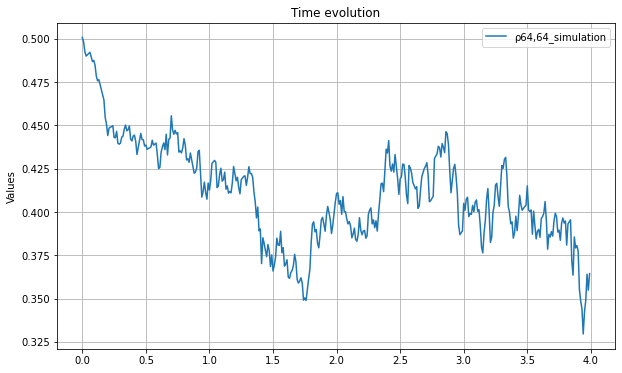

H_effective=
  (0, 0)	(1.23-1.1053878914033775j)
  (5, 0)	1.734723475976807e-18j
  (12, 0)	-0.13190746663539196j
  (9, 0)	-0.1305488029196028j
  (10, 0)	-0.009704740827065628j
  (4, 1)	-0.00970474082706563j
  (1, 1)	(1.07-1.300520055304503j)
  (2, 1)	(-0.5-0.006793318578945939j)
  (8, 1)	(-0.5+0.12026177764291324j)
  (13, 1)	-0.13870078521433793j
  (1, 2)	(-0.5+0.006793318578945939j)
  (2, 2)	(1.0000000000000002-1.1053878914033775j)
  (4, 2)	(-0.5+0.006793318578945939j)
  (7, 2)	3.469446951953614e-18j
  (14, 2)	-0.13870078521433793j
  (11, 2)	-0.13734212149854874j
  (8, 2)	-0.009704740827065628j
  (6, 3)	-0.009704740827065624j
  (3, 3)	(0.14000000000000018-1.300520055304503j)
  (5, 3)	(-0.5+0.006793318578945938j)
  (10, 3)	(-0.5+0.11346845906396727j)
  (15, 3)	-0.14549410379328387j
  (1, 4)	-0.00970474082706563j
  (2, 4)	(-0.5-0.006793318578945939j)
  (4, 4)	(0.9299999999999999-1.300520055304503j)
  :	:
  (11, 11)	(-0.9299999999999999-0.7637854129007188j)
  (13, 11)	(-0.5-0.00679331857

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import expm
from quspin.operators import hamiltonian, quantum_operator
from quspin.basis import spin_basis_1d
from scipy.sparse import csc_matrix,csr_matrix
from scipy.sparse.linalg import eigsh
from qutip import *


class QuantumSystem:

        
    def Heisenberg_xxz_sparse_hamiltonian(self):

        
        """Generate the sparse matrix representation of the Heisenberg XXZ Hamiltonian with an external field.
           Parameters:
           - L: int, spin chain length
           - J_0: float, interaction constant
           - h: float, external field strength
           - Delta: float, XXZ anisotropy parameter
           - delta: float, external field variation
           - Nup: int, number of up spins

           Returns:
           - H_spin_chain_sparse_csc: scipy.sparse.csc_matrix, sparse matrix representation of the Hamiltonian
           - dimension_basis: int, basis dimension
           - static: nested list, creates a list of time independent interaction terms in the XXZ Hamiltonian
           - dynamic: nested list, creates a list of interaction terms in XXZ Hamiltonian which explicitly depend on time
           - basis: quspin.basis.spin_basis_1d object, Basis object representing the states of the spin chain in Fock space.
           """
        L=4 
        J_0=1 
        h=J_0 # 
        Delta=0.7 
        delta=-0.07 
        Nup=None #spinless where up is one and no particle is zero unlike spinful
        
        basis=spin_basis_1d(L, Nup=Nup,pauli=False)
        
        
        J = [[-J_0,i,(i+1)%L] for i in range(L)] # creates site coupling list between two nearest neighbours i and i+1
        h_i=[[h + (i - 1) * delta, i] for i in range(L)]#potential height list 
        
        
        static = [["xx",J],["yy",J],["zz", [[-J_0 * Delta, i, (i + 1) % L]for i in range(L)]],["z", h_i]]
        dynamic=[]
        H_spin_chain = hamiltonian(static, dynamic, basis=basis, dtype=np.float64)
        H_spin_chain_sparse_csc = H_spin_chain.tocsc() #compressed sparse row matrix
        
        
        dimension_basis = basis.Ns
        
        return H_spin_chain_sparse_csc, dimension_basis, static, dynamic,basis
    
    
    
    
    
    
    
    def Coupling_operator(self):
        """ Generate the sparse matrix representation of the system coupling operator sigma_x coupled to the zero-th site.
        Returns:
        - sparse_sigma_x_1: scipy.sparse.csc_matrix, sparse matrix representation of the coupling operator"""
        sigma_x_1_dict = {"static": [["x", [[2,0]]]], "dynamic": []} #2 is the amplitude/prefactor of the operator and 0 the site index it acts on



        sigma_x_1 = quantum_operator(sigma_x_1_dict, basis=self.basis)
        matrix_representation=sigma_x_1.toarray()
        sparse_sigma_x_1=csc_matrix(matrix_representation)
        return sparse_sigma_x_1
    
    
    
    
    
    
    
    
    
    
    def Jump_operator(self):
        
        
        
        """ Calculate the jump operators in sparse matrix form
        Parameters:
        - ε: float, fixed expansion energy (in units of J_0)
        - γ: float, dissipation strength (in units of J_0)
        - E_D: float, Drude cuttoff energy (in units of J_0)
        - T: float, temperature (in units of J_0)
        - N_value: int, the order of expansion for nested commutator term in the approximate Redfield operator u^(N)
        Returns:
        - operators: list, a list of jump operators of pseudo-Lindblad type of Redfield equation (L_+ and L_-)
        - gammas: list, a list of strengths corresponding to each jump operator
        - u: scipy.sparse.csc_matrix, approximate Redfield operator
        - v: scipy.sparse.csc_matrix, the system coupling operator"""
        
        
        self.H_spin_chain_sparse_csc, _, _, _, _ = self.Heisenberg_xxz_sparse_hamiltonian()
        
        
        
        
        #parameters
        ε= 1 
        γ= 0.5 
        E_D= 20
        T= 2 
        N_value=2
        
        
        
        
        
        #functions
        n_B=(np.exp(ε/T)-1)**(-1) #occupation function
        J_D=(γ*ε)/(1+(ε**2/E_D**2)) #lorentz-Drude spectral density
        v= self.sparse_sigma_x_1 #system coupling operator
        
        W= J_D*n_B# real part of the fourier laplace transform W_D(E)
        
        
        #nested commutator summation calculation for higher order of u
        def compute_derivative(func, x, n, h=10**-2):
            if n == 0:
                return func(x)
            else:
                return (compute_derivative(func,x+h,n-1)-compute_derivative(func,x-h,n-1))/(2*h)
        
        def factorial(n):
            return 1 if n == 0 else n*factorial(n-1)
        
        def commutator(A,B):
            return A*B-B*A
        def nested_commutator(H_S, v, epsilon, n):
            result=v
            for _ in range(n):
                result= commutator(H_S, result)-epsilon*result
            return result
        def calculate_sum(n, epsilon, Temp, E_Drude, dissip_strength, H_S, v):
            def W_derivative(epsilon):
                return (dissip_strength*epsilon)/((1+epsilon**2/E_Drude**2)*(np.exp(epsilon / Temp)-1))
            sum_result=0
            for i in range(1,n+1):
                W_n_derivative= compute_derivative (W_derivative, epsilon, i)
                nested_commutator_result=nested_commutator(H_S, v,epsilon, i)
                sum_result+= (W_n_derivative/factorial(i))*nested_commutator_result
            return sum_result
        
        resulting_total_sum = calculate_sum(N_value, ε, T, E_D, γ, self.H_spin_chain_sparse_csc, v)
        
        #print(f"The sum for n={n_value} is: {resulting_total_sum}")
        
        if N_value == 0:
            u = W * v #+ resulting_total_sum  # zero-th order approx
        else:
            u = W * v + resulting_total_sum.tocsc()  # higher order approx
        
        
        
        
        L_plus=((np.sqrt(2*W))**(-1))*(u+W*v) #jump opeartor with positive magnitude
        L_minus=((np.sqrt(2*W))**(-1))*(u-W*v) #jump opeartor with negative magnitude
        
        
        operators = [L_plus,L_minus]
        gammas = [1,-1] #strengths associated to each jump operator in operators array
        return operators, gammas, u, v
    
    
    
    
    
    
    
    def Psi_initial(self):
        
        
        
        """Calculate the initial state vector in the Fock basis representation.
        Returns:
        - Psi_0=  numpy.ndarray, initial state vector |psi_0>=|n_0>+|n_1>/sqrt(2), with n_0 and n_1 
        as ground and first excited eigenstate of the XXZ Hamiltonian, in Fock basis representation"""
        
        
        
        dim=self.dimension_basis
        num_eigenstates = 2  # set how many eigenstates you want to calculate (starts from zero).
        eigenenergies, eigenstates = eigsh(self.H_spin_chain_sparse_csc, k=num_eigenstates, which='SA')
        
        
        # Normalize eigenstates
        eigenstates_normalized = eigenstates / np.linalg.norm(eigenstates, axis=0)
        
        # Initialize Fock basis states
        fock_basis_states = np.eye(dim)
        
        # Initialize array to store coefficients
        coefficients = np.zeros((num_eigenstates, dim), dtype=complex)
        
        
        # Calculate coefficients for each eigenstate
        for i in range(num_eigenstates):
            for j in range(dim):
                # Calculate overlap of eigenstate with Fock basis state
                overlap = np.dot(fock_basis_states[:, j].conj().T, eigenstates_normalized[:, i])
                coefficients[i, j] = overlap
        
        
        # Calculate the Fock basis representation of the eigenstate Psi_0
        norm_value = np.linalg.norm(coefficients[0]+coefficients[1])
        Psi_0=(coefficients[0]+coefficients[1])/norm_value #representative fock initial state of ground and first excited state of eigenbasis
        return Psi_0
    
    
    
    
    
    
    def Psi_normalized(self):
        """ Alternative method to generate an initial state in the Fock basis without calculating the eigenstates of
        the system Hamiltonian.
        Input:
        binary_repr: list, give binary represenation of states that you need to be non zero
        example: if L=2, then the possible fock basis are
        0.         |1 1>           3  
        1.         |1 0>           2  
        2.         |0 1>           1  
        3.         |0 0>           0 
        if you want the initial state as |psi_0>=(1,0,1,0)^T, then give 
        binary_repr = ["11","01"].
        Returns:
        psi_normalized: numpy.ndarray, the normalized initial state vector in the Fock basis representation."""
        
        
        
        basis=self.basis
        binary_repr = ["1111"]
        psi = np.zeros(basis.Ns, dtype=complex)
        for binary_state in binary_repr:
            i = basis.index(binary_state)
            psi[i] = 1.0
        psi_normalized=psi / np.linalg.norm(psi)
        return psi_normalized
    
    
    
    
    def Effective_hamiltonian(self):
        
        
        """Calculate the non-hermitian effective Hamiltonian for quantum trajectory algorithm.
        returns:
        Effective_hamiltonian:scipy.sparse.csc_matrix, effective hamiltonian matrix """
        
        
        H_sys = self.H_spin_chain_sparse_csr 
        H_LS=-0.5j*(self.v.dot(self.u) - self.u.conj().T @ self.v)#lambshift
        return H_sys +H_LS- 0.5j * sum(gamma * ((op.conj().T@ op)) for gamma, op in zip(self.gammas, self.operators))

    def jumpto(self, probs):
        
        
        
        """
        Choice of jump channel. For a given 1d-array of jump probabilities probs=[probability_1,...probability_N]
        pick one index with the associated probability.

        :param probs: 1d array of probabilities
        :return: integer that points to one of the states 0<=i<=N (N=len(probability))
        """
        
        
        # Normalize probabilities
        nprobs = np.array(probs) / sum(probs)

        # Generate a random number between 0 and 1
        rand = np.random.rand(1)

        # Calculate the cumulative sum of probabilities
        edge = np.cumsum(nprobs)

        # Check if the probabilities sum up to 1 (within a small tolerance)
        if np.abs(edge[-1] - 1) >= 1e-15:
            print('Probs do not sum up to one')
            sys.exit(1)

        # Determine the chosen channel by finding the first index where the cumulative sum exceeds the random number
        lessrand = (edge <= rand)
        choice = np.sum(lessrand, dtype=int)

        return choice

    def evolve_system(self,time_step, num_steps, num_repetitions):
        
        
        
        #calling all the necessary variables for the algorithm
        self.time_step = time_step
        self.num_steps = num_steps
        self.num_repetitions = num_repetitions
        self.H_spin_chain_sparse_csr, self.dimension_basis, self.static, self.dynamic,self.basis = self.Heisenberg_xxz_sparse_hamiltonian()
        self.sparse_sigma_x_1=self.Coupling_operator()
        self.operators, self.gammas,self.u,self.v=self.Jump_operator()
        self.Psi_0=self.Psi_initial()
        self.psi_normalized= self.Psi_normalized()
        self.H_eff = self.Effective_hamiltonian()
        
        
        #storing unchanging calculations here to avoid excess memory useage in the loops
        length_operator_array=len(self.operators)
        iden_mat=csc_matrix(np.identity(self.dimension_basis))
        op_array=self.operators
        conj_op_array=[matrix.conj().T for matrix in self.operators]
        approximate_time_evol_operator=( (iden_mat -1j*self.H_eff*self.time_step))
        U_t = expm(-1j * self.H_eff * self.time_step) #exact time evolution operator, can be used for better results but costs memory for higher dimensional matrices
        
        
        #Required arrays to store the results
        time_evolved_states = np.zeros((self.num_repetitions, self.num_steps, len(self.Psi_0)), dtype=complex)# time evolved state vectors
        inner_products = np.zeros((self.num_repetitions , self.num_steps, 1), dtype=complex)
        signs = np.ones((self.num_repetitions , self.num_steps), dtype=float) #signs s(t) array 
        average_density_matrices = np.zeros((self.num_steps, *self.H_eff.shape), dtype=complex) #density matrices avergaed over all trajectories for each time step
        
        
        

        for repetition in range(num_repetitions):
            
            state=self.Psi_0 #specify the initial state for initial time step of each rep
            
            
            sign = 1.0 #start with positive sign bit s(0)=+1
            

            for i in range(num_steps):
                conjugate_state=state.conj().T #convenient to specify this here for later use to avoid recurring calculation
               
                norm = np.real(np.dot(conjugate_state, state)) 
                
                
                

                p_values = np.zeros(length_operator_array) #array for jump rates j_χ  of each opeartor 
                probability = np.zeros(length_operator_array)# array to stores probabilities δp_χ of each operator 
                for op_index, (operator,operatorconjT, gamma) in enumerate(zip(op_array,conj_op_array, self.gammas)):
                    
                    
                    p_values[op_index] = abs(gamma)*np.real(conjugate_state@operatorconjT@operator @ state)/norm
                    
                probability = p_values * self.time_step

                rand = np.random.rand() #get random number r_1 

                
                if rand < np.sum(probability):
                    chosen_op_index = self.jumpto(probability) #send probability to jumpto function to choose which operator index gets used for jump
                    
                    chosen_operator = op_array[chosen_op_index]
                    
                    chosen_gamma=self.gammas[chosen_op_index]
                    absolute_chosen_gamma=abs(chosen_gamma)
                    chosen_p_value=p_values[chosen_op_index]
                    sign *= chosen_gamma / absolute_chosen_gamma
                    numerator = (chosen_operator @ state)  * np.sqrt(absolute_chosen_gamma)
                    denominator = np.sqrt(chosen_p_value)
                    
                        
                    state = numerator / denominator #evolution under jumps
                    
                else:
                    state=(approximate_time_evol_operator @state)/ np.sqrt(1 - np.sum(probability)) #unitary evolution
                    

                time_evolved_states[repetition, i, :] = state #stores the state at current time step and rep in the array
                
                
                signs[repetition, i] = sign #stories s(t+δt) in an array

                outer_product = np.outer(time_evolved_states[repetition, i, :], time_evolved_states[repetition, i, :].conj().T)
                inner_products[repetition, i] = signs[repetition, i] * np.real(
                    np.dot(time_evolved_states[repetition, i, :].conj().T, time_evolved_states[repetition, i, :])
                )

                outer_product = np.outer(time_evolved_states[repetition, i, :], time_evolved_states[repetition, i, :].conj().T)
                average_density_matrices[i] += signs[repetition, i] * outer_product #accumulates contributions to the density matrix over multiple repetitions for each time step
        for i in range(self.num_steps):
            average_density_matrices[i] /= np.sum(inner_products[:, i], axis=0)
     
        

        
           

        return time_evolved_states,  average_density_matrices, signs
        



def plot_results(times, average_density_matrices,signs):
    plt.figure(figsize=(10, 6))
    y = np.real(average_density_matrices[:, 15, 15])
    mean_signs = np.mean(signs, axis=0)
    plt.plot(times, y, label="ρ64,64_simulation")
    #plt.plot(times, mean_signs, label="Mean(signs)")
   
    plt.ylabel("Values")
    plt.grid(True)
    plt.legend()
    plt.title("Time evolution")
    plt.show()


def main():
    "all the values for time array can be adjusted here"
    time_step = 0.01
    t_min = 0
    t_max = 4
    num_steps = int(((t_max - t_min) / time_step))
    times = np.arange(t_min, t_max, time_step)
    "adjust this as per required number of trajectories for better accuracy"
    num_repetitions =100
    
    
    
    
    

    
    

    quantum_system = QuantumSystem()
    time_evolved_states, average_density_matrices ,signs= quantum_system.evolve_system(time_step, num_steps, num_repetitions)
    plot_results(times, average_density_matrices,signs)
    
    return quantum_system, average_density_matrices




if __name__ == "__main__":
    quantum_system_instance, average_density_matrices_result = main()
    H_eff = quantum_system_instance.Effective_hamiltonian()
   
    print("H_effective=")
    print(H_eff)
    
 

        
        
        
        
        
        
        